# <center>Project 03: Linear Regression</center>


# Thông tin sinh viên

- Họ và tên: Nguyễn Lê Hồ Anh Khoa
- MSSV: 23127211
- Lớp: 23CLC01


# Import


In [12]:
import pandas as pd
import numpy as np

# Import thêm dữ thư viện nếu cần

from typing import Dict, Any
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns  # Thêm seaborn cho countplot


# Đọc dữ liệu


In [13]:
# Đọc dữ liệu  bằng pandas
train = pd.read_csv("p03.train.csv")
test = pd.read_csv("p03.test.csv")

# Lấy các đặc trưng X và giá trị mục tiêu y cho các tập huấn luyện (train) và kiểm tra (test)
X_train = train.iloc[:, :-1]  # Dataframe (chứa 5 đặc trưng huấn luyện)
y_train = train.iloc[:, -1]  # Series    (chứa 1 giá trị mục tiêu huấn luyện)

X_test = test.iloc[:, :-1]  # Dataframe (chứa 5 đặc trưng kiểm tra)
y_test = test.iloc[:, -1]  # Series    (chứa 1 giá trị mục tiêu kiểm tra)

# Sinh viên có thể sử dụng các khác nếu cần


# Cài đặt hàm


In [14]:
def ds_overview(df: pd.DataFrame) -> pd.DataFrame:
    """
    Cung cấp tổng quan cơ bản về tập dữ liệu ở mức metadata.

    Tham số:
    --------
    df : pd.DataFrame
        DataFrame cần kiểm tra.

    Trả về:
    -------
    pd.DataFrame
        DataFrame với hai cột: Property và Value, để hiển thị tốt hơn trong Jupyter.
    """
    n_rows, n_cols = df.shape
    overview_data = {
        "Property": ["Number of rows", "Number of columns"],
        "Value": [int(n_rows), int(n_cols)],
    }
    return pd.DataFrame(overview_data)


def dtypes_table(df: pd.DataFrame) -> pd.DataFrame:
    """
    Trả về bảng tên cột và kiểu dữ liệu của chúng.

    Tham số
    -------
    df : pd.DataFrame
        DataFrame cần kiểm tra.

    Trả về
    -------
    pd.DataFrame
        DataFrame với hai cột:
        - column: tên cột
        - dtype : kiểu dữ liệu của cột (chuỗi)
    """

    return pd.DataFrame(
        {"column": df.columns, "dtype": [df[c].dtype.name for c in df.columns]}
    )


def uniques_table(df: pd.DataFrame) -> pd.DataFrame:
    """
    Đếm số lượng giá trị duy nhất trong mỗi cột.

    Tham số
    -------
    df : pd.DataFrame
        DataFrame cần kiểm tra.

    Trả về
    -------
    pd.DataFrame
        Bảng với:
        - column : tên cột
        - nunique: số lượng giá trị duy nhất
        Được sắp xếp theo thứ tự giảm dần của nunique.
    """
    out = pd.DataFrame(
        {
            "column": df.columns,
            "nunique": [df[c].nunique(dropna=True) for c in df.columns],
        }
    )
    return out.sort_values("nunique", ascending=False).reset_index(drop=True)


def missing_table(df: pd.DataFrame) -> pd.DataFrame:
    """
    Đếm số lượng giá trị thiếu và tỷ lệ phần trăm của chúng cho mỗi cột.

    Tham số
    ----------
    df : pd.DataFrame
        The DataFrame to inspect.

    Returns
    -------
    pd.DataFrame
        Table with:
        - column        : column name
        - missing_count : number of NaN values
        - missing_%     : percentage of NaN values relative to total rows
        Sorted in descending order by missing_count.
    """
    missing = df.isna().sum()
    pct = (missing / len(df) * 100.0) if len(df) else 0.0
    out = pd.DataFrame(
        {
            "column": df.columns,
            "missing_count": [int(missing[c]) for c in df.columns],
            "missing_%": [
                round(float(pct[c]), 3) if len(df) else 0.0 for c in df.columns
            ],
        }
    )
    return out.sort_values("missing_count", ascending=False).reset_index(drop=True)


def sample_values(df: pd.DataFrame, k: int = 5) -> pd.DataFrame:
    """
    Retrieve the first k non-null values for each column.

    Tham số
    ----------
    df : pd.DataFrame
        The DataFrame to inspect.
    k  : int, default=5
        Number of sample values to retrieve per column.

    Returns
    -------
    pd.DataFrame
        DataFrame with two columns: Column and Sample Values, for better display in Jupyter.
    """
    data = {"Column": [], "Sample Values": []}
    for c in df.columns:
        vals = df[c].dropna().head(k).tolist()
        data["Column"].append(c)
        data["Sample Values"].append(", ".join(map(str, vals)))
    return pd.DataFrame(data)


def head_tail(df: pd.DataFrame, n: int = 5) -> Dict[str, pd.DataFrame]:
    """
    Return the first and last n rows of the DataFrame.

    Tham số
    ----------
    df : pd.DataFrame
        The DataFrame to inspect.
    n  : int, default=5
        Number of rows to display from the start and end.

    Returns
    -------
    Dict[str, pd.DataFrame]
        {
          "head": first n rows,
          "tail": last n rows
        }
    """
    return {"head": df.head(n), "tail": df.tail(n)}


def eda_overview(
    X: pd.DataFrame,
    y: pd.Series,
    target_name: str = "target",
    sample_k: int = 5,
    head_tail_n: int = 5,
) -> Dict[str, Any]:
    """
    Perform a quick metadata-level EDA for both features (X) and target (y).

    Tham số
    ----------
    X : pd.DataFrame
        Feature matrix.
    y : pd.Series
        Target vector.
    target_name : str, default="target"
        Name to assign to the target column when combining with X.
    sample_k : int, default=5
        Number of sample values to show per column.
    head_tail_n : int, default=5
        Number of rows to display for head and tail.

    Returns
    -------
    Dict[str, Any]
        {
          "overview": dataset_overview_df,
          "dtypes": DataFrame,
          "uniques": DataFrame,
          "missing": DataFrame,
          "samples": DataFrame,
          "head_tail": {"head": DataFrame, "tail": DataFrame}
        }
    """
    # Combine X and y for inspection
    df_full = X.copy()
    df_full[target_name] = y.values

    return {
        "overview": ds_overview(df_full),
        "dtypes": dtypes_table(df_full),
        "uniques": uniques_table(df_full),
        "missing": missing_table(df_full),
        "samples": sample_values(df_full, k=sample_k),
        "head_tail": head_tail(df_full, n=head_tail_n),
    }


def plot_histograms(df, bins=30, exclude=None):
    """
    Vẽ biểu đồ histogram cho các cột số trong dataframe, loại trừ các cột được chỉ định.

    Args:
        df (pd.DataFrame): Đầu vào dataframe.
        bins (int): Số lượng bins cho các biểu đồ (mặc định là 30).
        exclude (list): Danh sách các cột cần loại trừ khỏi biểu đồ.
    """
    if exclude is None:
        exclude = []
    numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns
    numeric_cols = [col for col in numeric_cols if col not in exclude]
    df[numeric_cols].hist(bins=bins, figsize=(12, 10))
    plt.tight_layout()
    plt.show()


def plot_countplot(df, col):
    """
    Vẽ biểu đồ countplot (biểu đồ cột) cho một cột phân loại.

    Args:
        df (pd.DataFrame): Đầu vào dataframe.
        col (str): Tên cột để vẽ.
    """
    plt.figure(figsize=(8, 6))
    sns.countplot(x=col, data=df)
    plt.title(f"Count Plot of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()


def plot_scatter_vs_target(df, features, target):
    """
    Vẽ biểu đồ scatter cho từng đặc trưng số so với mục tiêu.

    Args:
        df (pd.DataFrame): Đầu vào dataframe.
        features (list): Danh sách các cột đặc trưng.
        target (str): Tên cột mục tiêu.
    """
    for feature in features:
        plt.figure(figsize=(8, 6))
        plt.scatter(df[feature], df[target])
        plt.xlabel(feature)
        plt.ylabel(target)
        plt.title(f"{feature} vs {target}")
        plt.show()


def plot_correlation_heatmap(df):
    """
    Vẽ biểu đồ heatmap của các mối tương quan giữa các cột số, với các giá trị được chú thích trong mỗi ô bằng seaborn.
    Args:
        df (pd.DataFrame): Đầu vào dataframe.
    """
    corr_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        corr_matrix,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        linewidths=0.5,
        cbar=True,
        annot_kws={"size": 12, "weight": "bold"},
        square=True,
    )
    plt.title("Correlation Heatmap", fontsize=14, weight="bold")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


def plot_pairwise_product_correlation_heatmap(df, target):
    """
    Vẽ biểu đồ heatmap của các mối tương quan giữa tất cả các sản phẩm cặp của các đặc trưng và mục tiêu.
    Args:
        df (pd.DataFrame): Đầu vào dataframe.
        target (str): Tên cột mục tiêu.
    """
    features = [col for col in df.columns if col != target]
    # Tạo các biến tổ hợp (cặp biến nhân nhau)
    product_features = {}
    for i in range(len(features)):
        for j in range(i, len(features)):
            f1, f2 = features[i], features[j]
            name = f"{f1} * {f2}" if f1 != f2 else f1
            product_features[name] = df[f1] * df[f2] if f1 != f2 else df[f1]
    # Thêm target
    product_features[target] = df[target]
    df_products = pd.DataFrame(product_features)
    # Tính ma trận tương quan
    corr_matrix = df_products.corr()
    plt.figure(figsize=(14, 10))
    sns.heatmap(
        corr_matrix,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        linewidths=0.5,
        cbar=True,
        annot_kws={"size": 8, "weight": "bold"},
        square=True,
    )
    plt.title(
        "Correlation Heatmap of Pairwise Products and Performance Index",
        fontsize=14,
        weight="bold",
    )
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


def plot_boxplots(df, features, target):
    """
    Vẽ boxplot cho từng feature (categorical hoặc numeric) so với target.
    Args:
        df (pd.DataFrame): DataFrame đầu vào.
        features (list): Danh sách các feature để vẽ.
        target (str): Tên cột target.
    """
    import seaborn as sns
    import matplotlib.pyplot as plt

    for feature in features:
        plt.figure(figsize=(8, 6))
        if (
            df[feature].dtype.name in ["object", "category"]
            or df[feature].nunique() < 10
        ):
            sns.boxplot(x=df[feature], y=df[target])
            plt.xlabel(feature)
        else:
            # Nếu là numeric, chia thành các bins để xem phân phối
            bins = min(10, df[feature].nunique())
            df_binned = df.copy()
            df_binned[feature + "_bin"] = pd.qcut(
                df[feature], q=bins, duplicates="drop"
            )
            sns.boxplot(x=df_binned[feature + "_bin"], y=df_binned[target])
            plt.xlabel(feature + " (binned)")
        plt.ylabel(target)
        plt.title(f"Boxplot of {target} by {feature}")
        plt.xticks(rotation=30)
        plt.tight_layout()
        plt.show()


def plot_pairplot(df):
    """
    Vẽ pairplot cho toàn bộ các feature và target.
    Args:
        df (pd.DataFrame): DataFrame đầu vào.
    """
    sns.pairplot(df, diag_kind="hist")
    plt.suptitle("Pairplot of Features", y=1.02, fontsize=16, weight="bold")
    plt.show()


def plot_all_charts(df, target):
    """
    Hàm để gọi tất cả các hàm vẽ biểu đồ.

    Args:
        df (pd.DataFrame): Đầu vào dataframe.
        target (str): Tên cột mục tiêu để vẽ biểu đồ.
    """
    # Plot histograms for numeric columns except 'Extracurricular Activities'
    plot_histograms(df, exclude=["Extracurricular Activities"])

    # Plot countplot for 'Extracurricular Activities' if exists
    if "Extracurricular Activities" in df.columns:
        plot_countplot(df, "Extracurricular Activities")

    # Plot boxplots for each feature (categorical and numeric) against target
    all_features = df.columns[df.columns != target].tolist()  # Exclude target
    plot_boxplots(df, all_features, target)

    # Plot correlation heatmap
    plot_correlation_heatmap(df)

    # Plot pairwise product correlation heatmap
    plot_pairwise_product_correlation_heatmap(df, target)

    plot_pairplot(df)


# 2a
def train_linear_regression(X, y):
    """
    Huấn luyện mô hình hồi quy tuyến tính (Linear Regression) sử dụng công thức giải tích (Normal Equation), không dùng thư viện.
    Args:
        X (np.ndarray): Ma trận đặc trưng, shape (n_samples, n_features)
        y (np.ndarray): Vector target, shape (n_samples,)
    Returns:
        w (np.ndarray): Vector trọng số, shape (n_features,)
        b (float): Hệ số tự do (intercept)
    """
    n_samples = X.shape[0]
    X_aug = np.hstack([X, np.ones((n_samples, 1))])
    w_full = np.linalg.pinv(X_aug.T @ X_aug) @ X_aug.T @ y
    w = w_full[:-1]
    b = w_full[-1]
    return w, b


def mean_squared_error(y_true, y_pred):
    """
    Tính Mean Squared Error (MSE) giữa giá trị thực tế và dự đoán.
    Args:
        y_true (np.ndarray): Vector giá trị thực tế.
        y_pred (np.ndarray): Vector giá trị dự đoán.
    Returns:
        float: Giá trị MSE.
    """
    return np.mean((y_true - y_pred) ** 2)


# 2b
def manual_shuffle(X_df, y_series):
    """
    Hàm trộn ngẫu nhiên các hàng của DataFrame và Series.

    Tham số
    ----------
    X_df : pd.DataFrame
        DataFrame cần trộn.
    y_series : pd.Series
        Target Series cần trộn.

    Returns
    -------
    X_shuffled : pd.DataFrame
        Đã trộn DataFrame.
    y_shuffled : pd.Series
        Đã trộn Series.
    """
    idx = np.arange(len(X_df))
    np.random.shuffle(idx)
    X_shuffled = X_df.iloc[idx].reset_index(drop=True)
    y_shuffled = y_series.iloc[idx].reset_index(drop=True)
    return X_shuffled, y_shuffled


def cross_validate_features(X, y, feature_names, k=5):
    """
    Thực hiện k-fold cross-validation cho mỗi đặc trưng (hồi quy 1D), trả về MSE và MSE trung bình cho mỗi đặc trưng.

    Tham số
    ----------
    X : pd.DataFrame
        Feature DataFrame (đã trộn).
    y : pd.Series
        Target Series (đã trộn).
    feature_names : list of str
        Dãy các đặc trưng.
    k : int, default=5
        Số lần lặp.

    Returns
    -------
    results : list of dict
        Each dict: {'feature': str, 'mses': list of float, 'avg_mse': float}
    """
    n = len(X)
    fold_size = n // k
    results = []
    for feature in feature_names:
        mses = []
        X_feat = X[[feature]].values
        y_arr = y.values
        for fold in range(k):
            start = fold * fold_size
            end = n if fold == k - 1 else (fold + 1) * fold_size
            X_val = X_feat[start:end]
            y_val = y_arr[start:end]
            X_train_fold = np.concatenate([X_feat[:start], X_feat[end:]], axis=0)
            y_train_fold = np.concatenate([y_arr[:start], y_arr[end:]], axis=0)
            w, b = train_linear_regression(X_train_fold, y_train_fold)
            y_pred = X_val @ w + b
            mse = mean_squared_error(y_val, y_pred)
            mses.append(mse)
        avg_mse = np.mean(mses)
        results.append({"feature": feature, "mses": mses, "avg_mse": avg_mse})
    return results


def display_cv_table(results):
    """
    Biểu diễn bảng tóm tắt kết quả cross-validation.

    Tham số
    ----------
    results : list of dict
        Đầu ra từ cross_validate_features, mỗi dict chứa 'feature', 'mses', 'avg_mse'.
    """
    cv_table = pd.DataFrame(
        {
            "STT": range(1, len(results) + 1),
            "Mô hình với 1 đặc trưng": [r["feature"] for r in results],
            "MSE": [f"{r['avg_mse']:.4f}" for r in results],
        }
    )
    display(cv_table)


def display_fold_detail_table(results, k=5):
    """
    Hiển thị bảng chi tiết MSE cho từng fold và từng đặc trưng bằng pandas DataFrame.

    Tham số
    ----------
    results : list of dict
        Đầu ra từ cross_validate_features, mỗi dict chứa 'feature', 'mses', 'avg_mse'.
    k : int, default=5
        Số lần lặp.
    """
    fold_cols = [f"Fold {i+1}" for i in range(k)]
    mse_detail_table = pd.DataFrame(
        [r["mses"] for r in results],
        columns=fold_cols,
        index=[r["feature"] for r in results],
    ).round(4)
    mse_detail_table["Avg MSE"] = [round(r["avg_mse"], 4) for r in results]
    display(
        mse_detail_table.style.format(precision=4).set_caption(
            "MSE từng fold cho từng đặc trưng"
        )
    )


# 2c
# Các hàm tạo mô hình custom
def create_model1(X_df):
    """
    Mô hình 1: Sử dụng 2 đặc trưng quan trọng nhất là Hours Studied (F1) và Previous Scores (F2)
    """
    return X_df[["Hours Studied", "Previous Scores"]]


def create_model2(X_df):
    """
    Mô hình 2: Loại bỏ Extracurricular Activities (F3), thêm bình phương của Previous Scores
    """
    X_model = X_df.copy()
    # Thêm đặc trưng bình phương
    X_model["Previous Scores^2"] = X_model["Previous Scores"] ** 2
    # Loại bỏ F3
    return X_model.drop(columns=["Extracurricular Activities"])


def create_model3(X_df):
    """
    Mô hình 3: Sử dụng đặc trưng tương tác giữa Hours Studied và Previous Scores
    """
    X_model = pd.DataFrame()
    X_model["Hours Studied * Previous Scores"] = (
        X_df["Hours Studied"] * X_df["Previous Scores"]
    )
    return X_model


def define_models():
    """
    Định nghĩa danh sách các mô hình để đánh giá

    Returns:
    --------
    list
        Danh sách các mô hình
    """
    return [
        {
            "name": "F1 + F2",
            "create_fn": create_model1,
            "description": "Sử dụng 2 đặc trưng quan trọng",
        },
        {
            "name": "F1 + F2 + F4 + F5 + F2^2",
            "create_fn": create_model2,
            "description": "Loại bỏ F3, Thêm bình phương của F2",
        },
        {
            "name": "F1 * F2",
            "create_fn": create_model3,
            "description": "Tương tác giữa F1 và F2",
        },
    ]


def cross_validate_custom_model(create_model_fn, X, y, k=5):
    """
    Thực hiện k-fold cross-validation trên một mô hình tùy chỉnh

    Tham số:
    -----------
    create_model_fn : function
        Hàm tạo DataFrame đặc trưng từ DataFrame gốc
    X : pd.DataFrame
        DataFrame đặc trưng gốc
    y : pd.Series
        Series giá trị mục tiêu
    k : int, default=5
        Số lượng fold

    Returns:
    --------
    dict
        Chứa MSE từng fold và MSE trung bình
    """
    n = len(X)
    fold_size = n // k
    mses = []

    for fold in range(k):
        # Chia dữ liệu thành training và validation
        start = fold * fold_size
        end = n if fold == k - 1 else (fold + 1) * fold_size

        X_val_fold = X.iloc[start:end]
        y_val_fold = y.iloc[start:end].values

        X_train_indices = list(range(0, start)) + list(range(end, n))
        X_train_fold = X.iloc[X_train_indices]
        y_train_fold = y.iloc[X_train_indices].values

        # Tạo đặc trưng cho mô hình
        X_train_model = create_model_fn(X_train_fold)
        X_val_model = create_model_fn(X_val_fold)

        # Huấn luyện mô hình
        w, b = train_linear_regression(X_train_model.values, y_train_fold)

        # Dự đoán và tính MSE
        y_pred = X_val_model.values @ w + b
        mse = mean_squared_error(y_val_fold, y_pred)
        mses.append(mse)

    avg_mse = np.mean(mses)
    return {"mses": mses, "avg_mse": avg_mse}


def evaluate_models(models, X, y, k=5):
    """
    Đánh giá tất cả các mô hình bằng k-fold cross validation

    Tham số:
    -----------
    models : list
        Danh sách các mô hình
    X : pd.DataFrame
        DataFrame đặc trưng
    y : pd.Series
        Series giá trị mục tiêu
    k : int, default=5
        Số lượng fold

    Returns:
    --------
    list
        Kết quả đánh giá các mô hình
    int
        Chỉ số của mô hình tốt nhất
    """
    # Xáo trộn dữ liệu
    X_shuffled, y_shuffled = manual_shuffle(X, y)

    # Đánh giá từng mô hình
    model_results = []
    for model in models:
        result = cross_validate_custom_model(
            model["create_fn"], X_shuffled, y_shuffled, k=k
        )
        model_results.append(
            {
                "name": model["name"],
                "description": model["description"],
                "mses": result["mses"],
                "avg_mse": result["avg_mse"],
            }
        )

    # Tìm mô hình tốt nhất
    best_model_idx = np.argmin([r["avg_mse"] for r in model_results])

    return model_results, best_model_idx


def display_model_results(model_results, best_model_idx, k=5):
    """
    Hiển thị kết quả đánh giá các mô hình

    Tham số:
    -----------
    model_results : list
        Kết quả đánh giá các mô hình
    best_model_idx : int
        Chỉ số của mô hình tốt nhất
    k : int, default=5
        Số lượng fold
    """
    best_model = model_results[best_model_idx]
    print(
        f"Mô hình tốt nhất là: {best_model['name']} với MSE trung bình: {best_model['avg_mse']:.4f}"
    )

    # Tạo bảng tổng kết
    cv_results_df = pd.DataFrame(
        {
            "STT": range(1, len(model_results) + 1),
            "Mô hình": [r["name"] for r in model_results],
            "MSE": [f"{r['avg_mse']:.4f}" for r in model_results],
        }
    )

    display(cv_results_df)

    # Hiển thị MSE chi tiết từng fold
    fold_columns = [f"Fold {i+1}" for i in range(k)]
    mse_details_df = pd.DataFrame(
        [r["mses"] for r in model_results],
        columns=fold_columns,
        index=[r["name"] for r in model_results],
    ).round(4)
    mse_details_df["Avg MSE"] = [round(r["avg_mse"], 4) for r in model_results]

    display(
        mse_details_df.style.format(precision=4).set_caption(
            "MSE từng fold cho từng mô hình"
        )
    )


def train_best_model(models, best_model_idx, X_train, y_train, X_test):
    """
    Huấn luyện mô hình tốt nhất và trả về thông tin mô hình

    Tham số:
    -----------
    models : list
        Danh sách các mô hình
    best_model_idx : int
        Chỉ số của mô hình tốt nhất
    X_train : pd.DataFrame
        DataFrame đặc trưng huấn luyện
    y_train : pd.Series
        Series giá trị mục tiêu huấn luyện
    X_test : pd.DataFrame
        DataFrame đặc trưng kiểm tra

    Returns:
    --------
    dict
        Thông tin về mô hình đã huấn luyện
    """
    best_model_name = models[best_model_idx]["name"]
    best_model_fn = models[best_model_idx]["create_fn"]

    # Tạo đặc trưng cho mô hình tốt nhất
    X_train_best = best_model_fn(X_train)
    X_test_best = best_model_fn(X_test)

    # Huấn luyện mô hình trên toàn bộ tập huấn luyện
    w_best_model, b_best_model = train_linear_regression(
        X_train_best.values, y_train.values
    )

    return {
        "name": best_model_name,
        "weights": w_best_model,
        "bias": b_best_model,
        "features": X_train_best.columns.tolist(),
        "X_test_transformed": X_test_best,
    }


def print_regression_formula(model_info):
    """
    In công thức hồi quy cho mô hình đã huấn luyện

    Tham số:
    -----------
    model_info : dict
        Thông tin về mô hình đã huấn luyện
    """
    formula_best_model = (
        "Student Performance = "
        + " + ".join(
            [
                f"({model_info['weights'][i]:.3f})*{model_info['features'][i]}"
                for i in range(len(model_info["weights"]))
            ]
        )
        + f" + ({model_info['bias']:.3f})"
    )

    print(f"\nCông thức hồi quy:")
    print(formula_best_model)


def evaluate_on_test_set(model_info, y_test):
    """
    Đánh giá mô hình trên tập kiểm tra

    Tham số:
    -----------
    model_info : dict
        Thông tin về mô hình đã huấn luyện
    y_test : pd.Series
        Series giá trị mục tiêu kiểm tra

    Returns:
    --------
    float
        MSE trên tập kiểm tra
    """
    # Dự đoán trên tập kiểm tra
    y_test_pred_best = (
        model_info["X_test_transformed"].values @ model_info["weights"]
        + model_info["bias"]
    )
    mse_test_best = mean_squared_error(y_test.values, y_test_pred_best)

    print(
        f"MSE trên tập kiểm tra với mô hình tốt nhất ({model_info['name']}): {mse_test_best:.4f}"
    )

    return mse_test_best


_Chú thích: Cần có docstrings cho các hàm._


# Yêu cầu 1: Phân tích khám phá dữ liệu


,Property,Value
0,Number of rows,9000
1,Number of columns,6


,column,dtype
0,Hours Studied,int64
1,Previous Scores,int64
2,Extracurricular Activities,int64
3,Sleep Hours,int64
4,Sample Question Papers Practiced,int64
5,Performance Index,float64


,column,nunique
0,Performance Index,91
1,Previous Scores,60
2,Sample Question Papers Practiced,10
3,Hours Studied,9
4,Sleep Hours,6
5,Extracurricular Activities,2


,column,missing_count,missing_%
0,Hours Studied,0,0.0
1,Previous Scores,0,0.0
2,Extracurricular Activities,0,0.0
3,Sleep Hours,0,0.0
4,Sample Question Papers Practiced,0,0.0
5,Performance Index,0,0.0


,Column,Sample Values
0,Hours Studied,"7, 8, 9, 4, 4"
1,Previous Scores,"77, 90, 83, 52, 82"
2,Extracurricular Activities,"0, 1, 1, 0, 1"
3,Sleep Hours,"5, 4, 6, 9, 8"
4,Sample Question Papers Practiced,"2, 1, 3, 5, 6"
5,Performance Index,"69.0, 84.0, 82.0, 38.0, 68.0"


,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,77,0,5,2,69.0
1,8,90,1,4,1,84.0
2,9,83,1,6,3,82.0
3,4,52,0,9,5,38.0
4,4,82,1,8,6,68.0


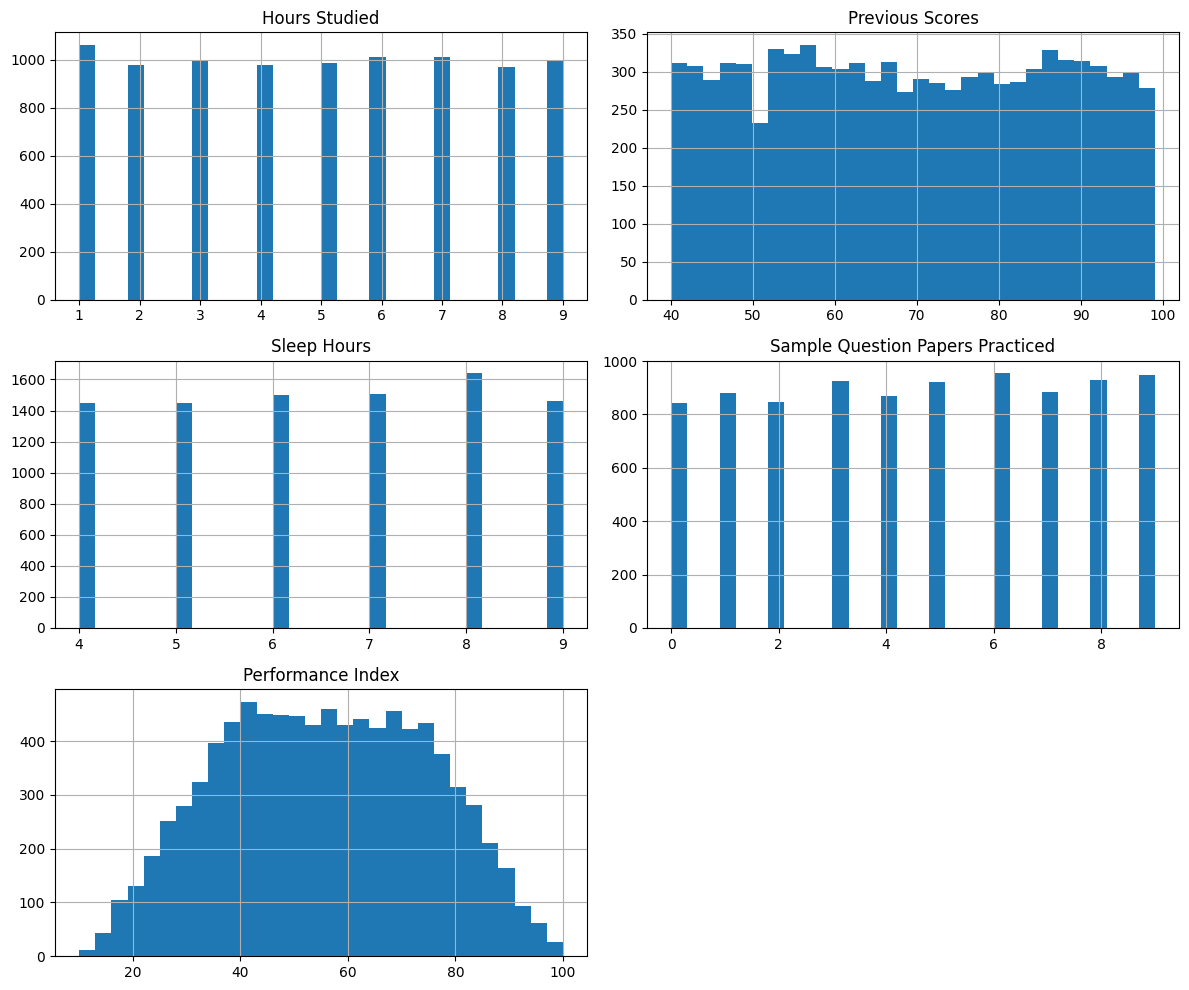

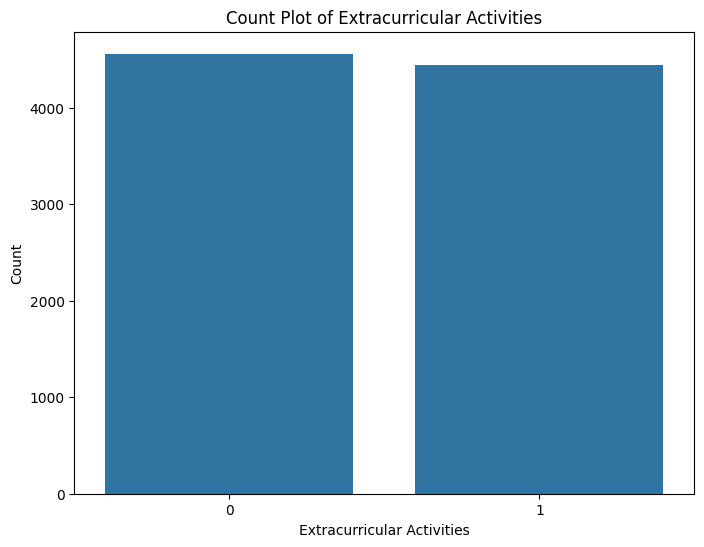

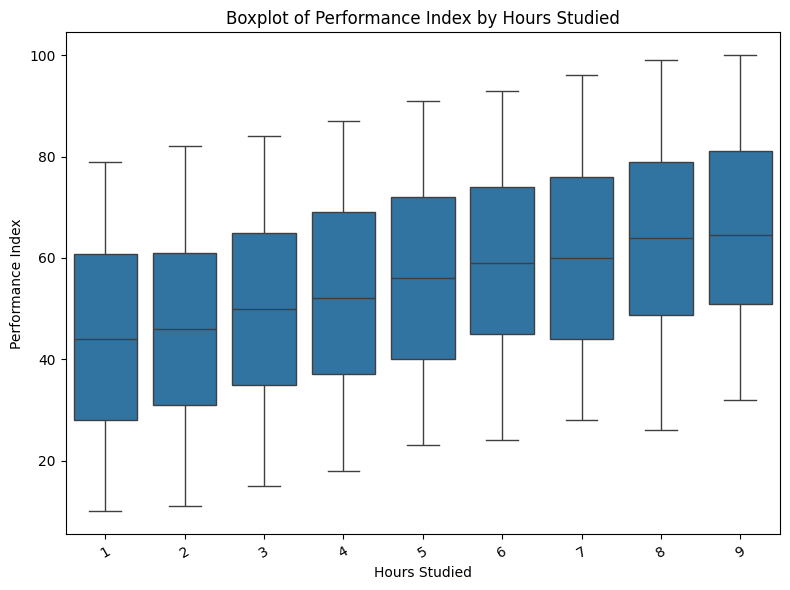

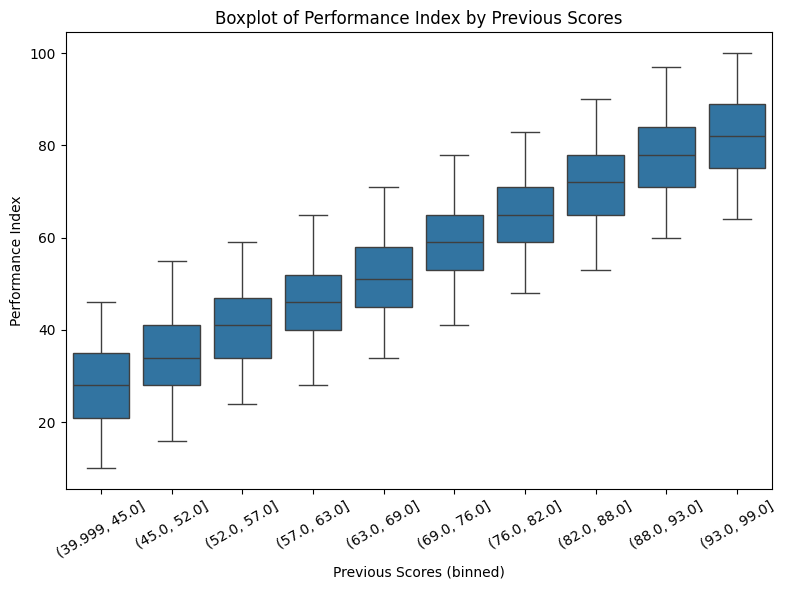

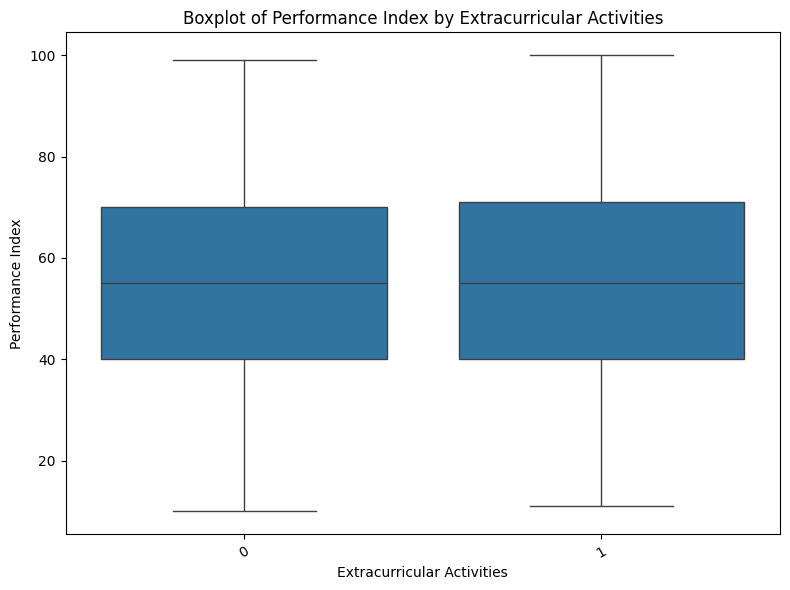

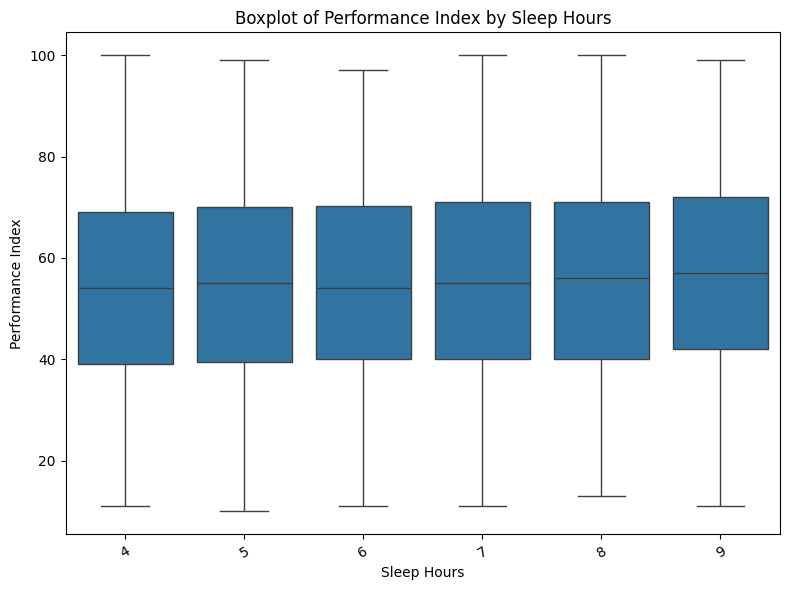

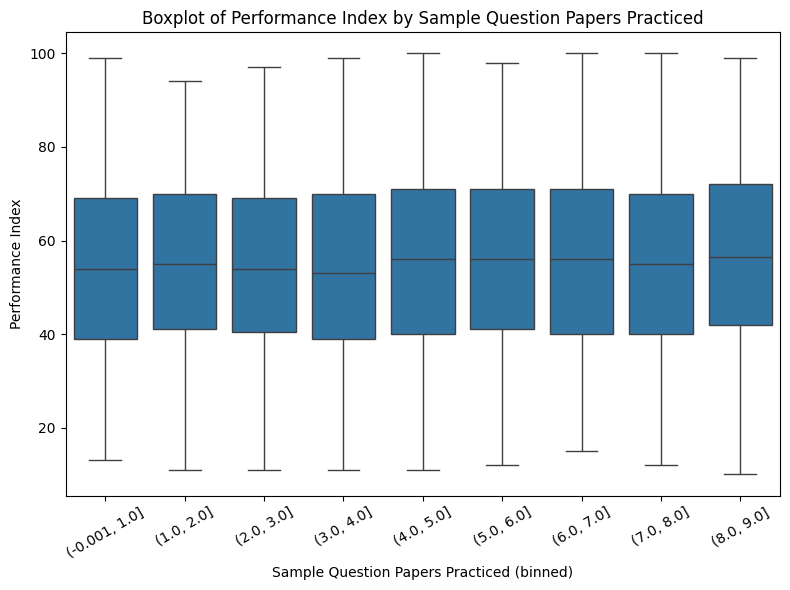

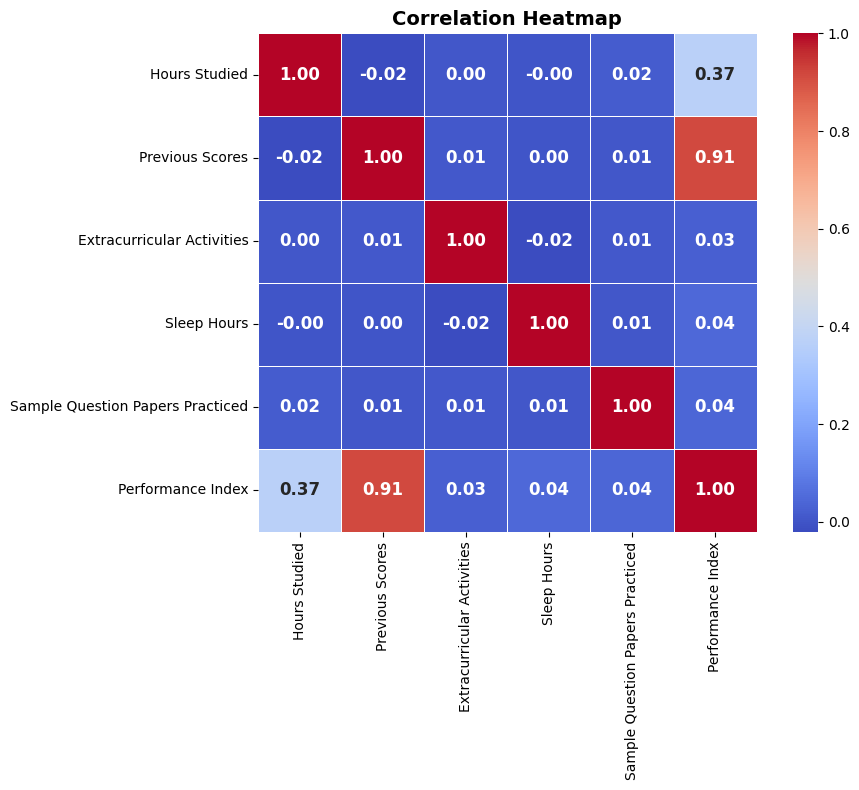

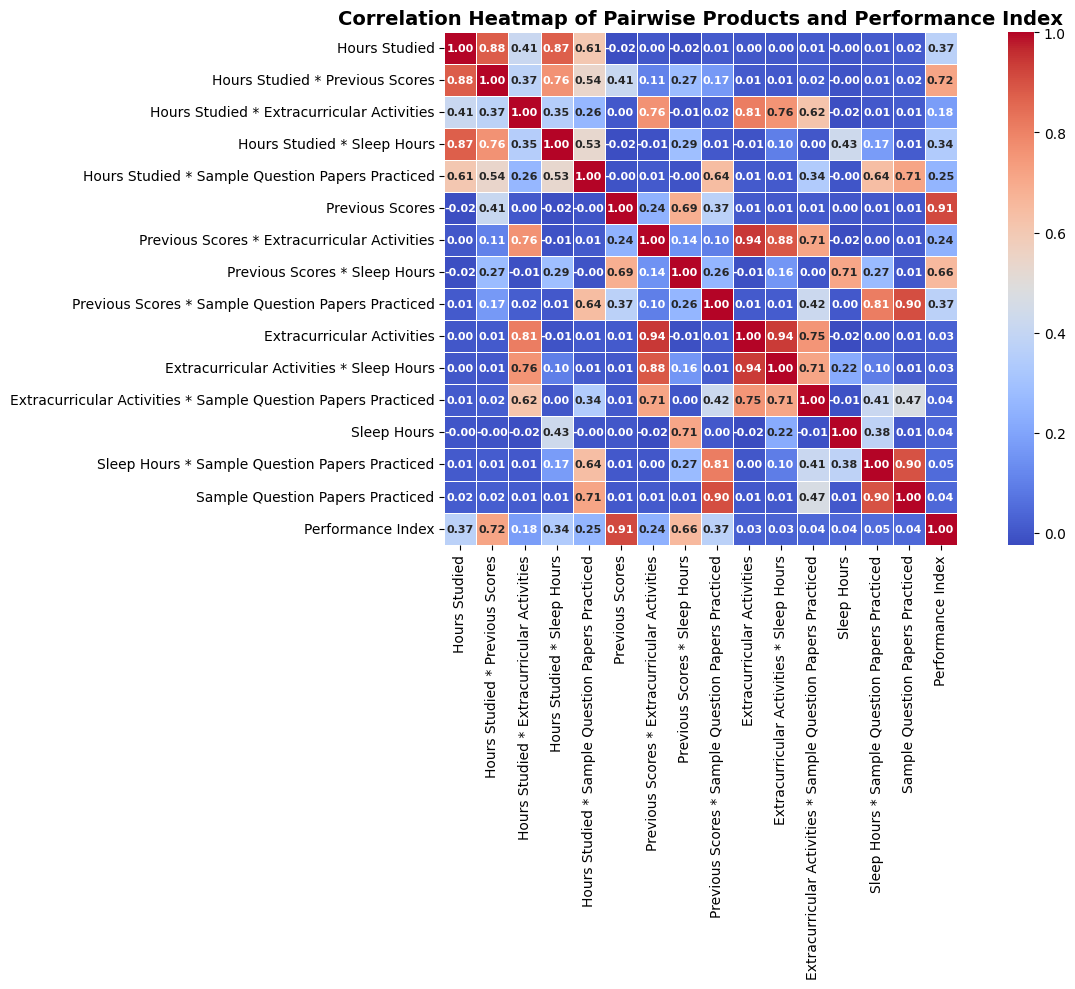

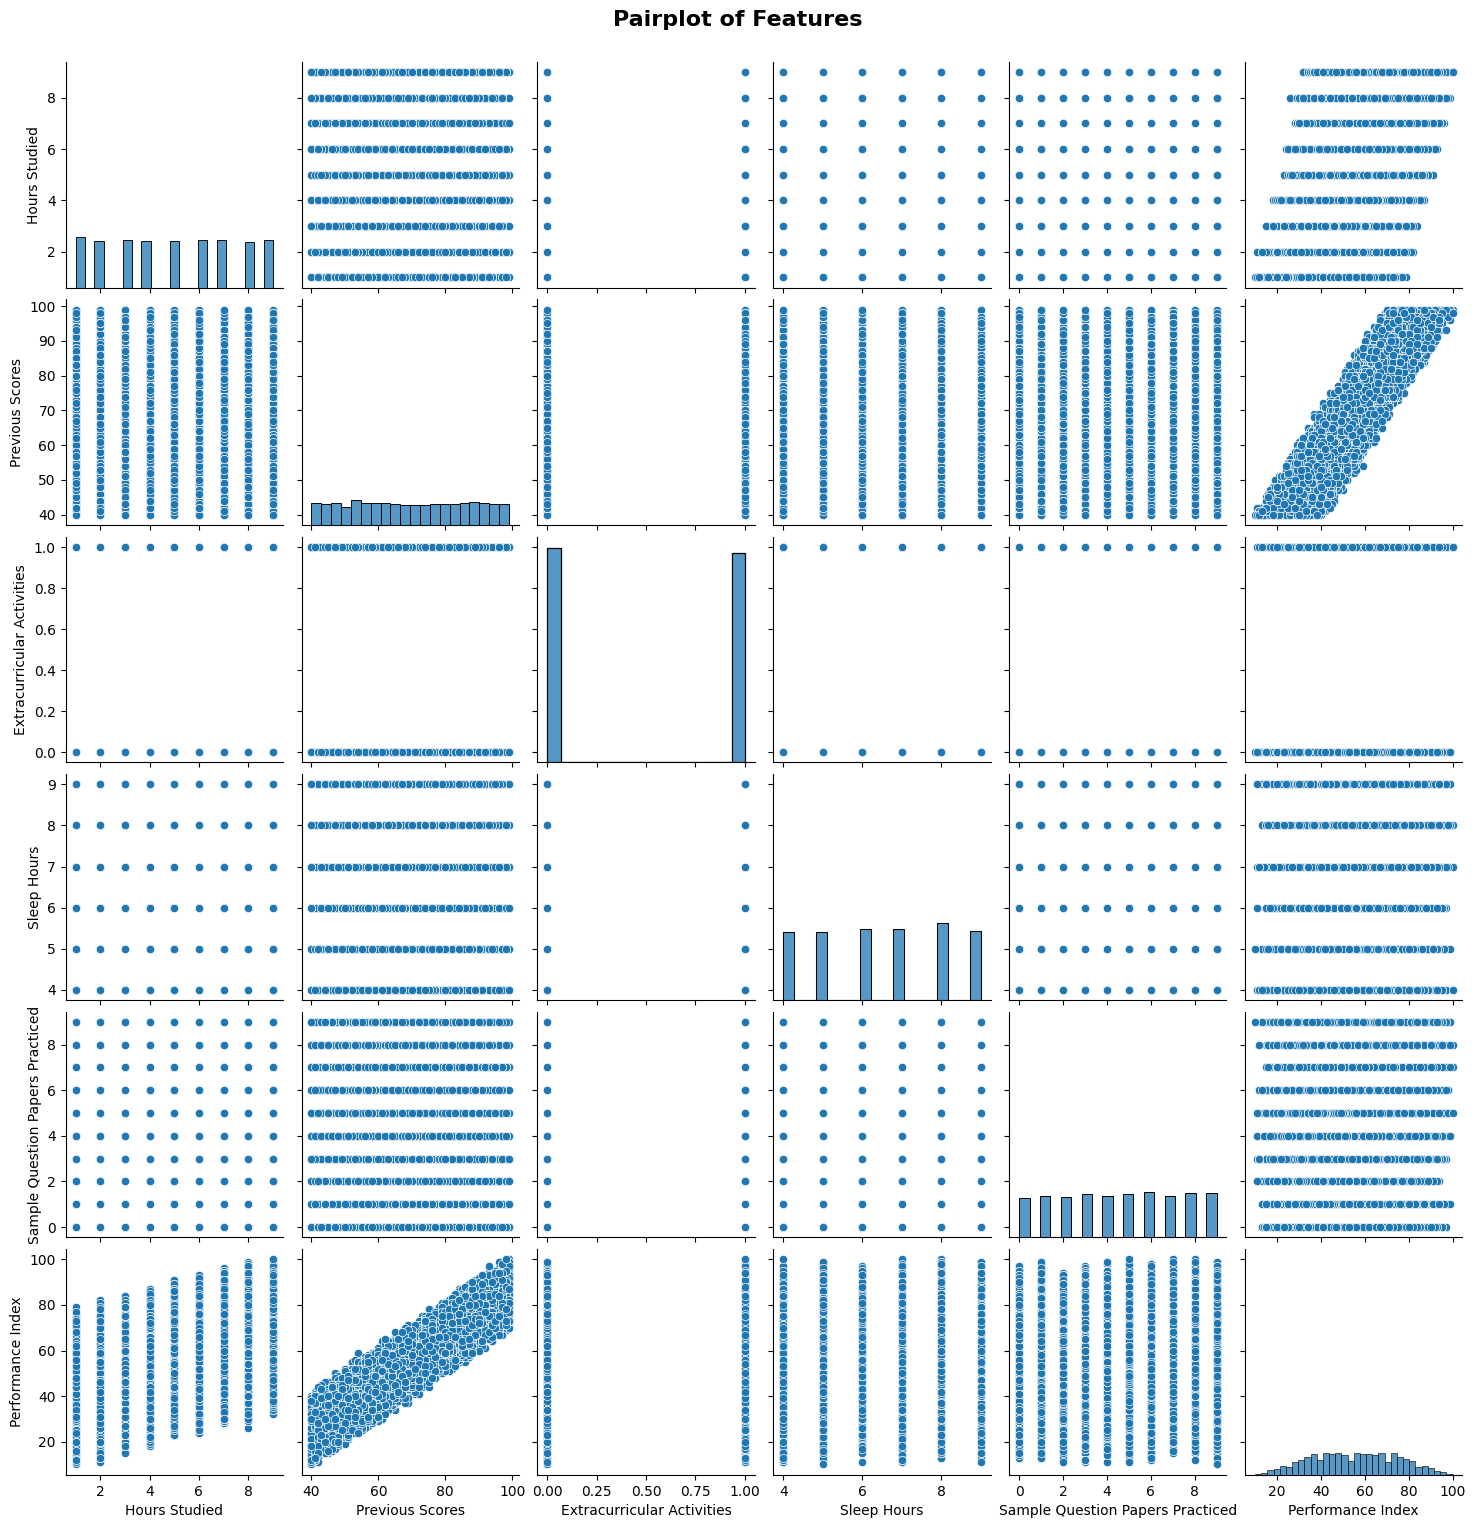

In [15]:
# Phân tích khám phá dữ liệu thông qua thống kê và các biểu đồ
# Chỉ được phân tích trên tập huấn luyện
report = eda_overview(X_train, y_train, target_name="Performance Index")

# Kiểm tra sơ lược tập dữ liệu
display(report["overview"])  # tổng quan
display(report["dtypes"])  # kiểu dữ liệu
display(report["uniques"])  # số lượng unique
display(report["missing"])  # missing values
display(report["samples"])  # giá trị mẫu
display(report["head_tail"]["head"])  # 5 dòng đầu

plot_all_charts(train, target="Performance Index")


# Yêu cầu 2a: Xây dựng mô hình sử dụng toàn bộ 5 đặc trưng đề bài cung cấp


In [16]:
# Gọi hàm huấn luyện và đánh giá
x = X_train.values
y = y_train.values
w, b = train_linear_regression(x, y)

# In công thức hồi quy
feature_names = X_train.columns.tolist()
formula = (
    "Student Performance = "
    + " + ".join([f"({w[i]:.3f})*{feature_names[i]}" for i in range(len(w))])
    + f" + ({b:.3f})"
)
print(formula)

# Dự đoán trên tập test
y_pred = X_test.values @ w + b
mse = mean_squared_error(y_test.values, y_pred)
print(f"MSE trên tập kiểm tra: {mse:.4f}")


Student Performance = (2.852)*Hours Studied + (1.018)*Previous Scores + (0.604)*Extracurricular Activities + (0.474)*Sleep Hours + (0.192)*Sample Question Papers Practiced + (-33.969)
MSE trên tập kiểm tra: 4.0925


Công thức hồi quy, phần trọng số làm tròn đến 3 chữ số thập phân, ví dụ 0.012345 $\to$ 0.012

$$\text{Student Performance} = (2.852)*Hours Studied + (1.018)*Previous Scores + (0.604)*Extracurricular Activities + (0.474)*Sleep Hours + (0.192)*Sample Question Papers Practiced + (-33.969)$$


# Yêu cầu 2b: Xây dựng mô hình sử dụng duy nhất 1 đặc trưng, tìm mô hình cho kết quả tốt nhất


Lưu ý: Khi sử dụng cross-validation, sinh viên cần xáo trộn dữ liệu 1 lần duy nhất và thực hiện trên toàn bộ đặc trưng


In [30]:
k = 5
feature_names = X_train.columns.tolist()
X_shuffled, y_shuffled = manual_shuffle(X_train, y_train)
results = cross_validate_features(X_shuffled, y_shuffled, feature_names, k=k)
display_cv_table(results)
display_fold_detail_table(results, k=k)
best_idx = np.argmin([r["avg_mse"] for r in results])
best_feature = results[best_idx]["feature"]
print(f"\nĐặc trưng tốt nhất: {best_feature}")


,STT,Mô hình với 1 đặc trưng,MSE
0,1,Hours Studied,317.9965
1,2,Previous Scores,60.1043
2,3,Extracurricular Activities,367.9951
3,4,Sleep Hours,367.5288
4,5,Sample Question Papers Practiced,367.6300


,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Avg MSE
Hours Studied,313.8764,315.5051,322.2938,319.8258,318.4813,317.9965
Previous Scores,59.5340,60.8386,59.8392,61.1274,59.1825,60.1043
Extracurricular Activities,360.0943,368.3405,375.3853,370.7093,365.4462,367.9951
Sleep Hours,359.3012,368.5612,375.3237,369.6954,364.7625,367.5288
Sample Question Papers Practiced,360.0332,367.4404,374.3134,371.0052,365.3577,367.6300



Đặc trưng tốt nhất: Previous Scores


In [28]:
# Huấn luyện lại mô hình best_feature_model với đặc trưng tốt nhất trên toàn bộ tập huấn luyện
X_best = X_train[[best_feature]].values
y = y_train.values
w_best, b_best = train_linear_regression(X_best, y)

# In công thức hồi quy
formula_best = (
    f"Student Performance = ({w_best[0]:.3f})*{best_feature} + ({b_best:.3f})"
)
print("Công thức hồi quy với đặc trưng tốt nhất:")
print(formula_best)


Công thức hồi quy với đặc trưng tốt nhất:
Student Performance = (1.011)*Previous Scores + (-14.989)


In [29]:
# Gọi hàm MSE
X_test_best = X_test[[best_feature]].values
y_test_pred = X_test_best @ w_best + b_best
mse_test = mean_squared_error(y_test.values, y_test_pred)
print(
    f"MSE trên tập kiểm tra (test.csv) với mô hình đặc trưng tốt nhất: {mse_test:.4f}"
)


MSE trên tập kiểm tra (test.csv) với mô hình đặc trưng tốt nhất: 58.8882


Công thức hồi quy (dựa trên mô hình đặc trưng tốt nhất), phần trọng số làm tròn đến 3 chữ số thập phân, ví dụ 0.012345 $\to$ 0.012

$$\text{Student Performance} = (1.011)*Previous Scores + (-14.989)$$


<center>

| STT |     Mô hình với 1 đặc trưng      |   MSE    |
| :-: | :------------------------------: | :------: |
|  1  |          Hours Studied           | 317.9965 |
|  2  |         Previous Scores          | 60.1043  |
|  3  |    Extracurricular Activities    | 367.9951 |
|  4  |           Sleep Hours            | 367.5288  |
|  5  | Sample Question Papers Practiced | 367.6300  |

## </center>

<center>

| STT | Mô hình với đặc trưng tốt nhất trên tập test |   MSE   |
| :-: | :------------------------------------------: | :-----: |
|  1  |               Previous Scores                | 58.8882 |

</center>


# Yêu cầu 2c: Sinh viên tự xây dựng/thiết kế mô hình, tìm mô hình cho kết quả tốt nhất


Các biến sau đây sẽ được sử dụng để thể hiện các đặc trưng:
| Variable | Feature Description |
|---------------|-----------------------------------|
| $F_1$ | Hours Studied |
| $F_2$ | Previous Scores |
| $F_3$ | Extracurricular Activities |
| $F_4$ | Sleep Hours |
| $F_5$ | Sample Question Papers Practiced |

## Thiết kế và Công thức các Mô hình

### **Mô hình 1**

Dựa trên heatmap, **Previous Scores** $F_2$ và **Hours Studied** $F_1$ có ảnh hưởng lớn nhất đến **Performance Index**.  
Mô hình sử dụng tổng của hai đặc trưng này:

$$ \text{Student Performance} = \alpha*{0} + \alpha*{1}F*{1} + \alpha*{2}F\_{2} $$

### **Mô hình 2**

Từ phân tích Count Plot và heatmap, **Extracurricular Activities** $F_3$ được loại bỏ do ảnh hưởng nhỏ. Thêm vào bình phương  

$$\text{Student Performance} = \alpha_{0} + \alpha_{1}F_{1} + \alpha_{2}F_{2} + \alpha_{3}F_{4} + \alpha_{4}F_{5} +  \alpha_{5}F_{2}^2 $$

### **Mô hình 3**

Sử dụng đặc trưng tương tác giữa **Hours Studied** $F_1$ và **Previous Scores** $F_2$:

$$\text{Student Performance} = \alpha_{0} + \alpha_{1}(F_{1} \times F_{2}) $$


## Tìm mô hình cho kết quả tốt nhất


Lưu ý: Khi sử dụng cross-validation, sinh viên cần xáo trộn dữ liệu 1 lần duy nhất và thực hiện trên toàn bộ $m$ mô hình mà sinh viên thiết kế


In [25]:
# Định nghĩa các mô hình
models = define_models()

# Thực hiện k-fold cross-validation và đánh giá các mô hình
k = 5  # Số lượng fold
model_results, best_model_idx = evaluate_models(models, X_train, y_train, k=k)

# Hiển thị kết quả
display_model_results(model_results, best_model_idx, k=k)


Mô hình tốt nhất là: F1 + F2 + F4 + F5 + F2^2 với MSE trung bình: 4.2580


,STT,Mô hình,MSE
0,1,F1 + F2,5.2010
1,2,F1 + F2 + F4 + F5 + F2^2,4.2580
2,3,F1 * F2,179.5046


,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Avg MSE
F1 + F2,5.2129,5.3706,5.3202,5.1506,4.9509,5.2010
F1 + F2 + F4 + F5 + F2^2,4.2488,4.4493,4.3918,4.3022,3.8981,4.2580
F1 * F2,171.8141,174.6237,184.3341,177.7668,188.9843,179.5046


In [26]:
# Huấn luyện mô hình tốt nhất
best_model_info = train_best_model(models, best_model_idx, X_train, y_train, X_test)

print(f"Mô hình tốt nhất: {best_model_info['name']}")
print_regression_formula(best_model_info)


Mô hình tốt nhất: F1 + F2 + F4 + F5 + F2^2

Công thức hồi quy:
Student Performance = (2.853)*Hours Studied + (1.028)*Previous Scores + (0.470)*Sleep Hours + (0.193)*Sample Question Papers Practiced + (-0.000)*Previous Scores^2 + (-33.982)


In [27]:
# Đánh giá mô hình tốt nhất trên tập kiểm tra
mse_test_best = evaluate_on_test_set(best_model_info, y_test)


MSE trên tập kiểm tra với mô hình tốt nhất (F1 + F2 + F4 + F5 + F2^2): 4.2076


Công thức hồi quy (dựa trên mô hình tốt nhất mà sinh viên tự xây dựng/thiết kế), phần trọng số làm tròn đến 3 chữ số thập phân, ví dụ 0.012345 $\to$ 0.012

$$\text{Student Performance} = (2.853)*Hours Studied + (1.028)*Previous Scores + (0.470)*Sleep Hours + (0.193)*Sample Question Papers Practiced + (-33.982)$$


<center>

| STT | Mô hình                                      |   MSE    |
|:---:|----------------------------------------------|:--------:|
|  1  | Mô hình sử dụng 2 đặc trưng quan trọng nhất  | 5.1973   |
|  2  | Mô hình mở rộng với biến bình phương         | 4.2567   |
|  3  | Mô hình tương tác                            | 179.4644 |

</center>

--

<center>

| STT | Mô hình tốt nhất chạy trên tập test                         |  MSE   |
|:---:|----------------------------------|:------:|
|  1  | Mô hình mở rộng với biến bình phương     | 4.2076 |

</center>
